### Simple Example for sea-level rise projections following the methodology of Mengel et al. PNAS (2016).

See v1.0.0 of the example for reproducing the figures of Mengel et al., PNAS 2016.

This notebook shows the basic usage of the sea level projection code. It builds on openly available IPCC AR5 global mean temperature timeseries. It is an adaption of `do_projections.py`.

We also illustrate the parametrization for the Antarctic ice sheet, introduced in v2.0.0, which mimics the Deconto & Pollard 2016 ice sheet response to global warming. 

In [1]:
%matplotlib inline

In [2]:
""" matthias.mengel@pik
"""
import os, glob, sys
import numpy as np
import matplotlib.pylab as plt
import netCDF4 as nc
import dimarray as da
# import cPickle as pickle
sys.path.append("../")
import settings; reload(settings)
import sealevel.projection as pr; reload(pr)
import sealevel.get_ipcc_data; reload(sealevel.get_ipcc_data)
import sealevel.plotting; reload(sealevel.plotting)

# plot settings
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markeredgewidth'] = 2
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = 12, 10
plt.rcParams['figure.facecolor'] = "white"

rcpcoldict = {"rcp26": "#2256A6", "rcp45": "#73B2E1", "rcp85": "#EE322D"}

# probabilistic climate need MAGICC ensemble, not openly available.
settings.probablistic_climate = False

In [3]:
# Create the sea level projections by sampling probabilstically 
# from the several sea level functions and their calibrations.

# choose which contributions to project (here as in PNAS 2016 paper)
settings.project_these = ["thermexp", "gic", "gis_smb", "gis_sid", "ant_smb", "ant_sid"]

for scen in settings.scenarios:

    print "scenario", scen

    if settings.probablistic_climate:
        # 600 member ensemble, you need the (non-open) data first
        gmt = mag.magicc_gmt[scen]
    else:
        # single timeseries from IPCC AR5
        gmt = sealevel.get_ipcc_data.tas_data[scen]
        
    pr.project_slr(scen, gmt, settings)

scenario rcp26
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_smb
conribution ant_sid
Sea level projection data written to
/home/mengel/projects/sealevel/data/projection
scenario rcp45
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_smb
conribution ant_sid
Sea level projection data written to
/home/mengel/projects/sealevel/data/projection
scenario rcp85
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_smb
conribution ant_sid
Sea level projection data written to
/home/mengel/projects/sealevel/data/projection


In [4]:
def percentiles(darray,list_of_percentiles):
    pdict = {}
    for p in list_of_percentiles:
        perc = np.percentile(darray.values,p,axis=1)
        pdict[p] = perc
    return pdict

def get_as_dimarray(ncf,variable):

    time = ncf.variables["time"][:]
    runnumber = ncf.variables["runnumber"][:]
    var  = ncf.variables[variable][:]
    dd = da.DimArray(var,dims=["time","runnumber"],
                     axes=[time,runnumber])
    return dd

scenario rcp26
scenario rcp45
scenario rcp85


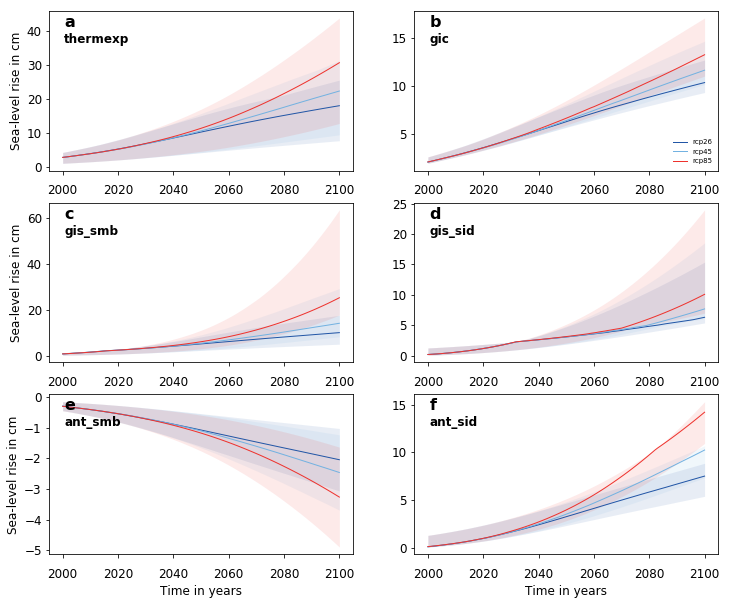

In [5]:
# Components as used in PNAS 2016 paper.
axs = []
for i in range(6):
    axs.append(plt.subplot(3, 2,i+1))

for scen in settings.scenarios:

    print "scenario", scen    

    ncm = nc.Dataset(os.path.join(settings.projected_slr_folder,
                                  "projected_slr_"+scen+"_n"+str(settings.nrealizations)+".nc"),"r")
    for i,contrib in enumerate(settings.project_these):
        ax = axs[i]

        lbl = scen if contrib=="gic" else None
        slr = get_as_dimarray(ncm,contrib)
        pc = percentiles(slr[2000:]*100,[5,50,95]) # in cm
        ax.plot(slr[2000:].time,pc[50],label=lbl,color=rcpcoldict[scen],lw=1)
        ax.fill_between(slr[2000:].time,pc[5],pc[95],color=rcpcoldict[scen],
                        alpha=0.1,lw=0)
    ncm.close()

string = "abcdef"
for i,contrib in enumerate(settings.project_these):
    ax = axs[i]
    ax.text(0.05, 0.9, string[i], transform=ax.transAxes,
    fontdict={'family': 'sans-serif', 'weight': 'bold', "size": 16})
    ax.text(0.05, 0.8, contrib, transform=ax.transAxes,
    fontdict={'family': 'sans-serif', 'weight': 'bold'})
    # ax.set_ylim(0,100)

lgd = axs[1].legend(loc="lower right",fontsize=7,ncol=1)
lgd.get_frame().set_linewidth(0.0)

for ax in axs[-2:]:
    ax.set_xlabel("Time in years")

for ax in [axs[0],axs[2],axs[4]]:
    ax.set_ylabel("Sea-level rise in cm")

In [6]:
# Updated Antarctic component, following Deconto & Pollard 2016.
# This component has been used in Nauels et al. 2017, Environmental Research Letters
# and Mengel et al. Nature Communications, forthcoming.
# This is only for illustration, as the global mean temperature ensembles are not 
# available publicly. 

settings.project_these = ["thermexp", "gic", "gis_smb", "gis_sid", "ant_dp16"]

for scen in settings.scenarios:

    print "scenario", scen

    if settings.probablistic_climate:
        # 600 member ensemble, you need the (non-open) data first
        gmt = mag.magicc_gmt[scen]
    else:
        # single timeseries from IPCC AR5
        gmt = sealevel.get_ipcc_data.tas_data[scen]
        
    pr.project_slr(scen, gmt, settings)

scenario rcp26
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_dp16


../sealevel/contributor_functions.py:326: UserWarning: Global mean temperature does not reach back to 1850,
but Deconto & Pollard Antarctic parametrization needs 1850 temperature.
Using first available temperature as proxy. (Not later than 1880).
  UserWarning)


Sea level projection data written to
/home/mengel/projects/sealevel/data/projection
scenario rcp45
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_dp16
Sea level projection data written to
/home/mengel/projects/sealevel/data/projection
scenario rcp85
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_dp16
Sea level projection data written to
/home/mengel/projects/sealevel/data/projection


scenario rcp26
scenario rcp45
scenario rcp85


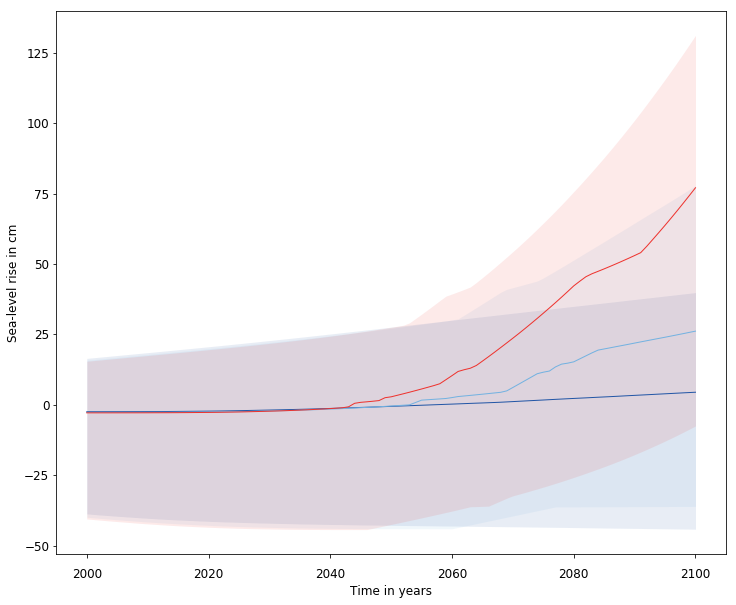

In [7]:
# Plotting the Deconto & Pollard component.

ax = plt.subplot(111)

for scen in settings.scenarios:

    print "scenario", scen    

    ncm = nc.Dataset(os.path.join(settings.projected_slr_folder,
                                  "projected_slr_"+scen+"_n"+str(settings.nrealizations)+".nc"),"r")


    lbl = scen if contrib=="gic" else None
    slr = get_as_dimarray(ncm,"ant_dp16")
    pc = percentiles(slr[2000:]*100,[5,50,95]) # in cm
    ax.plot(slr[2000:].time,pc[50],label=lbl,color=rcpcoldict[scen],lw=1)
    ax.fill_between(slr[2000:].time,pc[5],pc[95],color=rcpcoldict[scen],
                    alpha=0.1,lw=0)
    ncm.close()
    
ax.set_xlabel("Time in years")
ax.set_ylabel("Sea-level rise in cm")